In [21]:
import src.fetch as fetch
import src.process as process
import pandas as pd
import numpy as np



from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LassoCV, RidgeCV, RidgeClassifierCV, SGDClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
client = fetch.client("credentials.json")

query = fetch.FULL_QUERY

In [3]:
data = fetch.fetch_data(client, query)
data.head()

,Q001,Q006,nota_final,pop,pib_pc,cv_polio,hcsap,macsap,mi5,subnutricao,...,ga19,ppau,ti,pgcm,pnpcm,vci,vcn,vcm,ees,mees
0,H,G,2654.0,95832,44304.781657,89.245283,1057.244276,206.701719,17.681729,4.198653,...,13.490504,1.911055,0.699937,0.454416,0.900853,254.668930,86.380651,260.957117,58.881551,77.380565
1,C,C,2592.9,7788,28530.854186,50.537634,216.543958,60.733767,24.691358,5.790501,...,9.876543,0.000000,0.000000,0.232117,0.799323,0.000000,138.312586,53.648069,38.346910,61.443299
2,E,H,3092.5,12627,25261.954407,74.248927,467.411062,164.213754,13.761468,4.608661,...,16.055046,2.382872,2.129194,0.691360,0.781631,24.390244,31.446541,213.534823,38.424459,56.554524
3,B,B,2366.0,5351,44879.911717,81.250000,2348.529702,158.685738,22.017030,4.317789,...,15.625000,5.112426,0.000000,0.449230,0.742219,0.000000,57.971014,151.114469,42.963371,62.500000
4,E,G,2503.2,95832,44304.781657,89.245283,1057.244276,206.701719,17.681729,4.198653,...,13.490504,1.911055,0.699937,0.454416,0.900853,254.668930,86.380651,260.957117,58.881551,77.380565


In [4]:
data.shape

(721426, 57)

In [6]:
df_unified = data.copy()

# Calcular a diferença em relação à média da faixa de renda
df_unified['nota_diff'] = df_unified['nota_final'] - df_unified.groupby('Q006')['nota_final'].transform('mean')

# Transformar em variável binária
# 1 = desempenho acima da média para a faixa de renda
# 0 = desempenho abaixo da média para a faixa de renda
df_unified['above_average'] = (df_unified['nota_diff'] > 0).astype(int)

# Converter Q006 para variáveis dummy
# df_unified = pd.get_dummies(df_unified, columns=['Q006'], prefix='renda')
# df_unified = pd.get_dummies(df_unified, columns=['Q001'], prefix='escolaridade_dos_pais')

# Definir features e target
X_ips = df_unified.drop(columns=["Q006", "Q001", "nota_final", "nota_diff", "above_average"])


In [10]:
# Padronizar os dados para o PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ips)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Analisar a variância explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

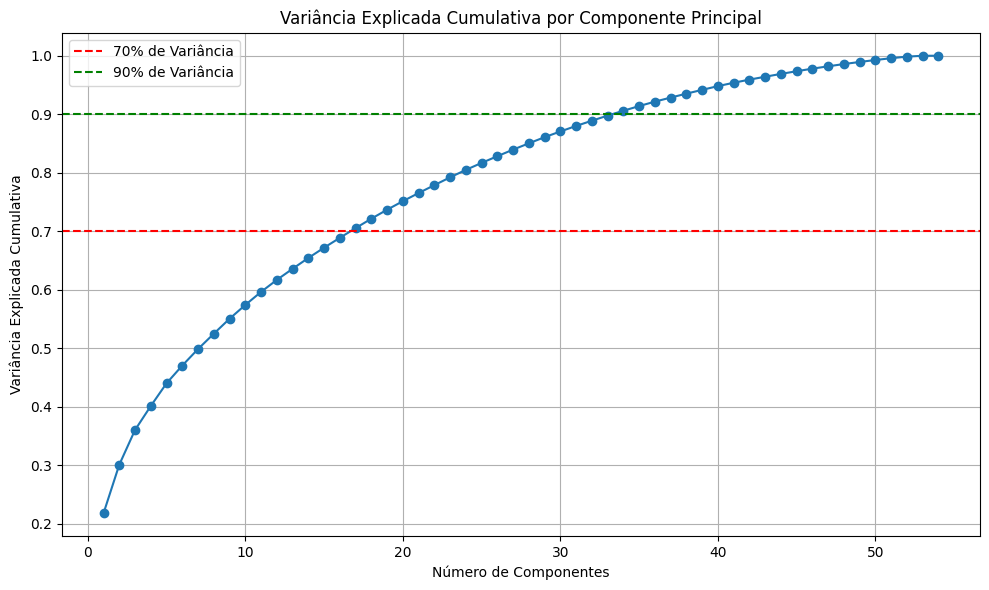

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Cumulativa')
plt.axhline(y=0.7, color='r', linestyle='--', label='70% de Variância')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% de Variância')
plt.grid(True)
plt.legend()
plt.title('Variância Explicada Cumulativa por Componente Principal')
plt.tight_layout()
plt.savefig('variance_explained.png', dpi=300)
plt.show()

In [14]:
n_components = np.argmax(cumulative_variance >= 0.7) + 1
print(f"Número de componentes necessários para explicar 70% da variância: {n_components}")

Número de componentes necessários para explicar 70% da variância: 17


In [15]:
pca_final = PCA(n_components=n_components)
X_pca_final = pca_final.fit_transform(X_scaled)

# Criar DataFrame com os componentes
pca_df = pd.DataFrame(
    X_pca_final,
    columns=[f'PC{i+1}' for i in range(n_components)]
)

components_df = pd.DataFrame(
    pca_final.components_,
    columns=X_ips.columns,
    index=[f'PC{i+1}' for i in range(n_components)]
)


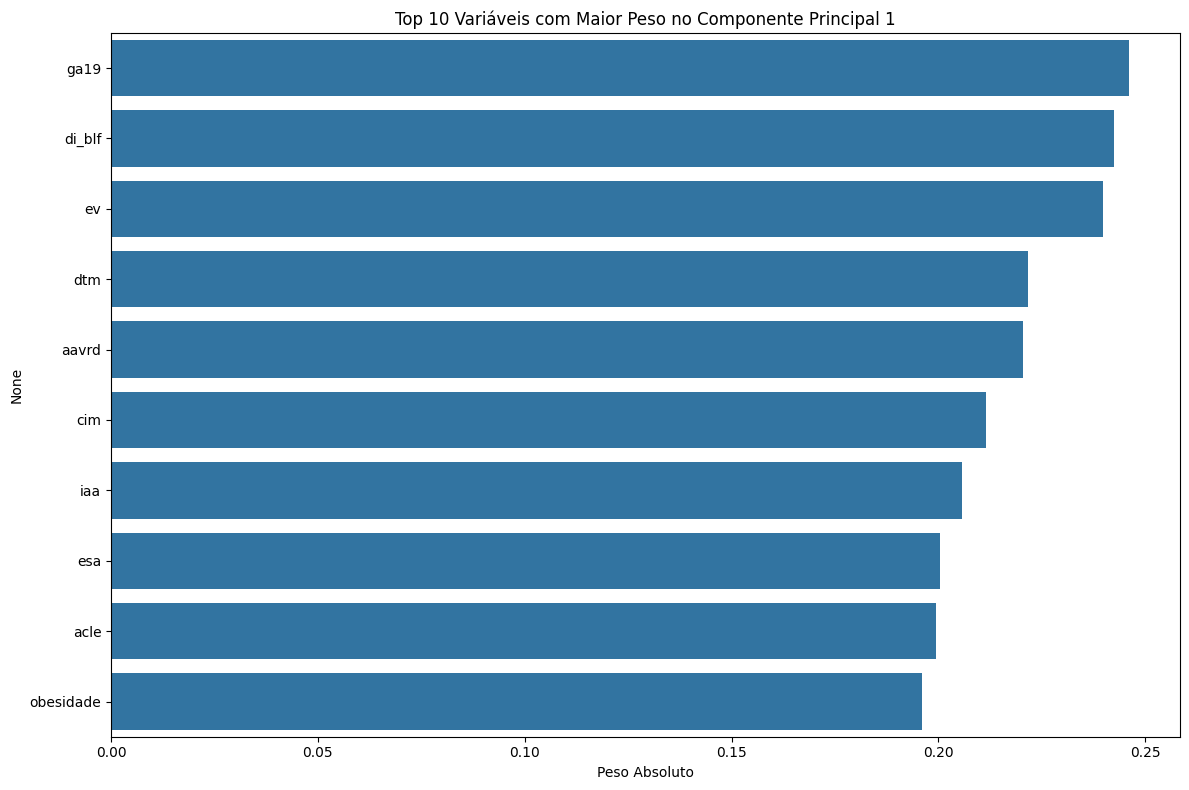

In [16]:
plt.figure(figsize=(12, 8))
component_weights = components_df.loc['PC1'].abs().sort_values(ascending=False)
top_variables = component_weights.head(10).index
sns.barplot(x=component_weights[top_variables], y=top_variables)
plt.title('Top 10 Variáveis com Maior Peso no Componente Principal 1')
plt.xlabel('Peso Absoluto')
plt.tight_layout()
plt.savefig('pc1_composition.png', dpi=300)
plt.show()

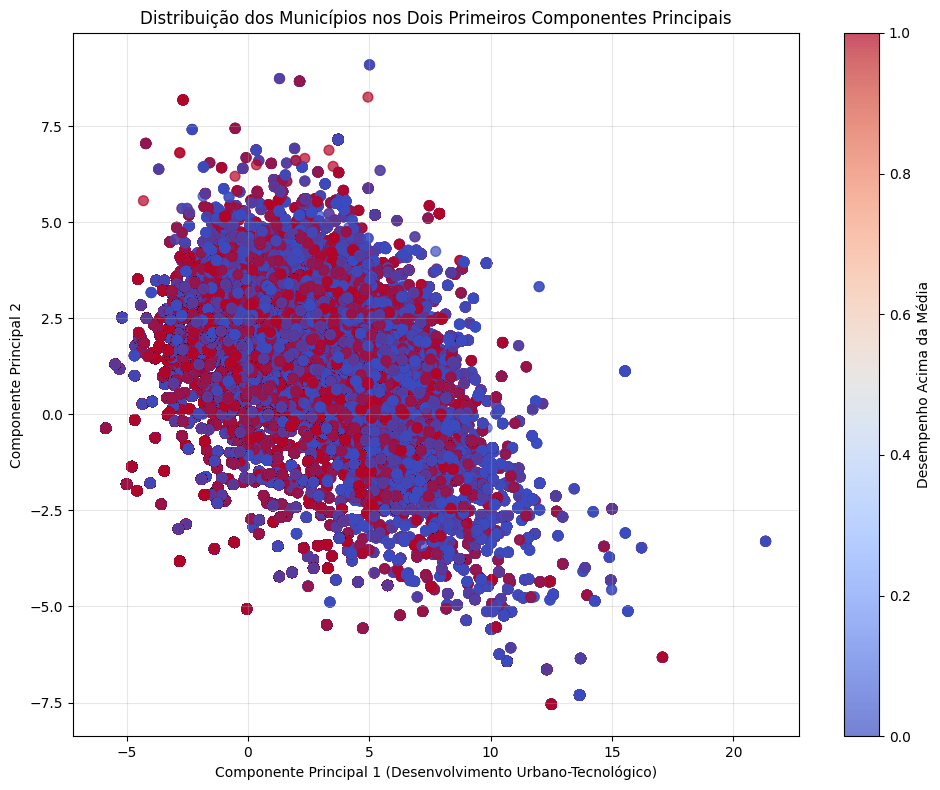

In [17]:
# Adicionar os componentes principais ao dataframe original
df_with_pca = df_unified.copy()
for i in range(n_components):
    df_with_pca[f'PC{i+1}'] = X_pca_final[:, i]

# Visualizar a relação entre PC1, PC2 e desempenho
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_with_pca['PC1'], 
    df_with_pca['PC2'],
    c=df_with_pca['above_average'],
    cmap='coolwarm',
    alpha=0.7,
    s=50
)
plt.colorbar(scatter, label='Desempenho Acima da Média')
plt.xlabel('Componente Principal 1 (Desenvolvimento Urbano-Tecnológico)')
plt.ylabel('Componente Principal 2')
plt.title('Distribuição dos Municípios nos Dois Primeiros Componentes Principais')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_scatter.png', dpi=300)
plt.show()

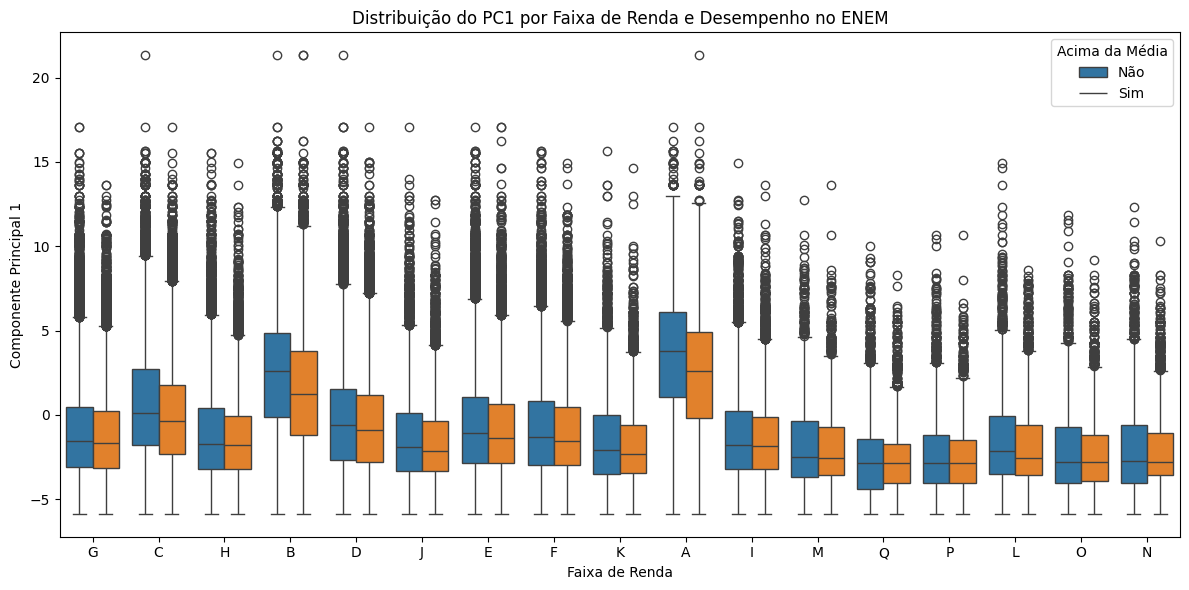

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Q006', y='PC1', hue='above_average', data=df_with_pca)
plt.xlabel('Faixa de Renda')
plt.ylabel('Componente Principal 1')
plt.title('Distribuição do PC1 por Faixa de Renda e Desempenho no ENEM')
plt.legend(title='Acima da Média', labels=['Não', 'Sim'])
plt.tight_layout()
plt.savefig('pc1_by_income_performance.png', dpi=300)
plt.show()


Média de PC1 em municípios acima da média: -0.3064
Média de PC1 em municípios abaixo da média: 0.3299
Diferença: -0.6363

Importância dos Componentes Principais no modelo:
    feature  importance
0       PC1    0.061425
18  renda_B    0.054492
19  renda_C    0.049666
20  renda_D    0.044761
2       PC3    0.041038
21  renda_E    0.039690
8       PC9    0.037023
1       PC2    0.036539
17  renda_A    0.036363
23  renda_G    0.036262
22  renda_F    0.032951
3       PC4    0.032791
5       PC6    0.032078
7       PC8    0.030706
12     PC13    0.029955
6       PC7    0.028446
24  renda_H    0.028251
16     PC17    0.028135
13     PC14    0.027861
4       PC5    0.026605
9      PC10    0.026546
10     PC11    0.025896
15     PC16    0.025826
11     PC12    0.025364
14     PC15    0.024692
25  renda_I    0.022522
26  renda_J    0.021280
27  renda_K    0.017979
28  renda_L    0.014877
30  renda_N    0.012978
29  renda_M    0.012582
33  renda_Q    0.012074
31  renda_O    0.012063
32  renda_P 

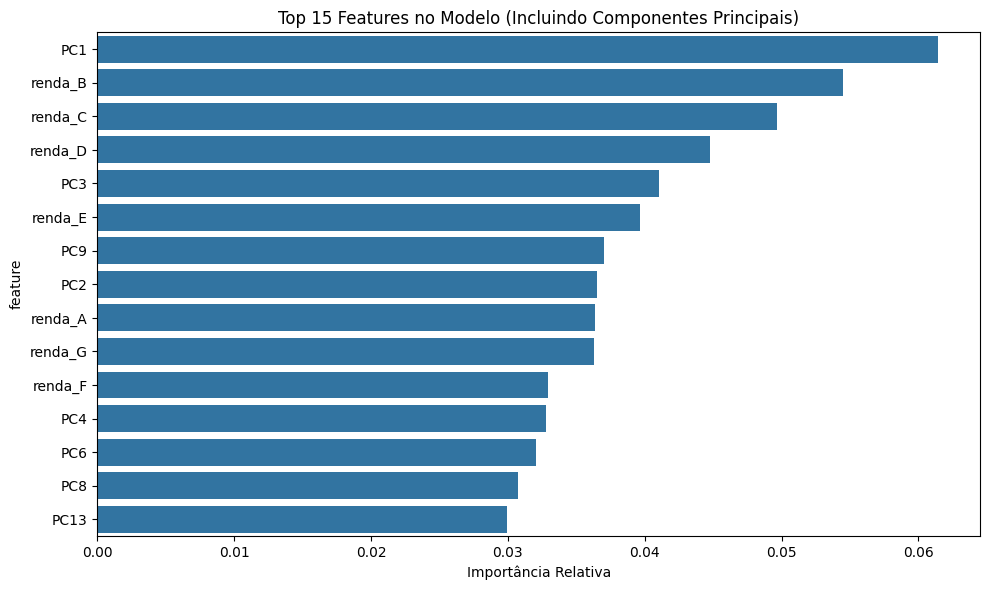

In [23]:

# Analisar como PC1 varia entre os grupos de desempenho
high_performers = df_with_pca[df_with_pca['above_average'] == 1]
low_performers = df_with_pca[df_with_pca['above_average'] == 0]

print(f"Média de PC1 em municípios acima da média: {high_performers['PC1'].mean():.4f}")
print(f"Média de PC1 em municípios abaixo da média: {low_performers['PC1'].mean():.4f}")
print(f"Diferença: {high_performers['PC1'].mean() - low_performers['PC1'].mean():.4f}")

# Criar um nome interpretável para PC1 baseado em suas principais variáveis
pc1_name = "Índice de Desenvolvimento Urbano-Tecnológico"
renda_dummies = pd.get_dummies(df_unified['Q006'], prefix='renda')
# Incluir os componentes principais em um modelo de classificação
# para validar sua importância
X_for_model = pd.concat([pca_df, renda_dummies.reset_index(drop=True)], axis=1)
y = df_unified['above_average'].reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X_for_model, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Analisar importância dos componentes
importances = pd.DataFrame({
    'feature': X_for_model.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nImportância dos Componentes Principais no modelo:")
print(importances)

# Visualizar a importância dos componentes
plt.figure(figsize=(10, 6))
top_features = importances.head(15)
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 15 Features no Modelo (Incluindo Componentes Principais)')
plt.xlabel('Importância Relativa')
plt.tight_layout()
plt.savefig('pca_feature_importance.png', dpi=300)
plt.show()

In [25]:
model.score(X_test, y_test)

0.5748097528519746